# Imports, Definitions & Functions

In [ ]:

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import seaborn as sns
import os
import sys


from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from sklearn.feature_selection import mutual_info_classif 


In [ ]:

def time2timestamp(days): 
  ''' 
  takes in a numpy array of representing calendar days of when each sample were collected. 
  return a numpy array of timestamp (integers) to be used an ordinal feature
  ''' 
  counter = 0 
  timestamp = np.zeros_like(days, dtype = int) 
  for i in range(1, len(timestamp)) : 
    if days[i] != days[i-1]: 
      counter += 1 
    timestamp[i] = counter
  return timestamp 


def get_periodic_stats(df):
  '''
  returns 2 Data Frame that has monthly and daily statistics about features 
  derived and added with the feature's name + '_monthly' or '_daily', respectively.
  '''
  month_groubed = df.groupby('month').sum()
  day_groubed = df.groupby('day').sum()
  monthly_new_features = month_groubed.transpose()[df.month].transpose().drop(columns = ['day'], axis = 1).astype(dtype = np.int32).rename(columns = lambda x : x + '_monthly')
  daily_new_features = day_groubed.transpose()[df.day].transpose().drop(columns = ['month'], axis = 1).astype(dtype = np.int32).rename(columns = lambda x : x + '_daily')
  return monthly_new_features.reset_index(drop = True), daily_new_features.reset_index(drop = True)


def time2timestamp(df):
  '''
  drops 'test_date' and creates 'month' and 'day' as two separated features
  to separate statstics related per month vs per day. 
  '''
  df = df.copy() 

  df['test_date'] = pd.to_datetime(df.test_date, infer_datetime_format = True) 
  df['month'] = df.test_date.dt.month 
  df['day'] = df.test_date.dt.day
  df.drop(columns = ['test_date'], inplace = True) 
  return df 

def binarize_features(df):
  df = df.copy() 

  results = df.corona_result.values
  age_above_60 = df.age_60_and_above.values 
  gender = df.gender.values 

  binary_age = [1 if age_above_60[i] == 'Yes' else 0 for i in range(len(df)) ]
  binary_results = [1 if results[i] == 'positive' else 0 for i in range(len(df)) ]
  binary_gender = [1 if gender[i] == 'male' else 0 for i in range(len(df)) ]
  df['corona_result'] = np.array(binary_results, dtype = np.int32)  
  df['age_60_and_above'] = np.array(binary_age, dtype = np.int32)
  df['gender'] = np.array(binary_gender, dtype = np.int32) 

  df = df.assign(test_indication = lambda x : x.test_indication == 'Contact with confirmed')
  # may also drop 'gender', 'age_60_and_above' because they have missing values, 
  # but will keep them for now since they will be part of the anlaysis
  # df.drop(columns = ['test_indication'], axis = 1, inplace = True) 
  return df 


In [ ]:
%%capture 

def download_data():
  # download the data file 
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies \
    --no-check-certificate 'https://docs.google.com/uc?export=download&id=1u78Z2-WhhyHzoHf6OtBnxWETnjBw7pg8' \
    -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1u78Z2-WhhyHzoHf6OtBnxWETnjBw7pg8" -O corona_tested_individuals_ver_0083.english.csv && rm -rf /tmp/cookies.txt
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies \
    --no-check-certificate 'https://docs.google.com/uc?export=download&id=1u8R1viz0ty6zR2CuVghRPQrv5XwDNOpk' \
    -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1u8R1viz0ty6zR2CuVghRPQrv5XwDNOpk" -O corona_tested_individuals_ver_006.english.csv && rm -rf /tmp/cookies.txt


# download the data file
download_data()

# Not play 1

In [ ]:
df = pd.read_csv('corona_tested_individuals_ver_0083.english.csv')
df = time2timestamp(df) 
df = binarize_features(df) 
m_df, d_df = get_periodic_stats(df) 
new_df = pd.concat([df, m_df, d_df], axis =1) 

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
y_features = 'corona_result'
x_features = [col for col in new_df.columns if col != y_features]
x, y = new_df[x_features].to_numpy(dtype = np.float32), new_df[y_features].to_numpy(dtype = np.float32)
x.shape, y.shape, x.dtype, y.dtype

((2742596, 28), (2742596,), dtype('float32'), dtype('float32'))

In [ ]:
features = x_features
contributions = mutual_info_classif(x, y)

In [ ]:
features, contributions = zip(*(sorted(zip(contributions.tolist(), features))))

In [ ]:
np.sum(features)

1.4701186261447639

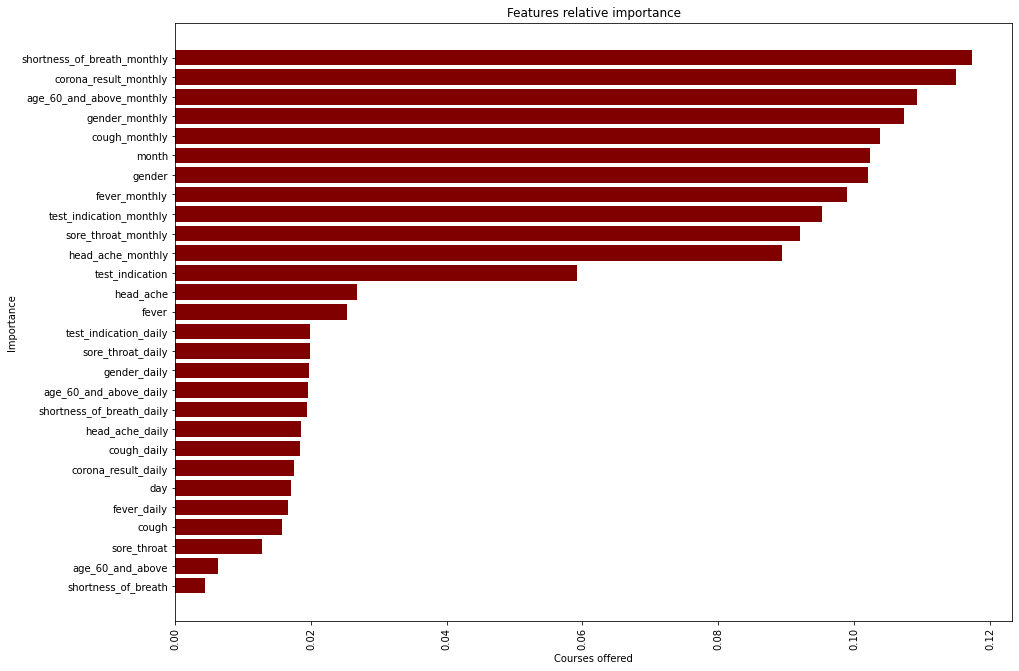

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
 
  
fig = plt.figure(figsize = (15, 11))

# creating the bar plot
plt.barh(contributions, features, color ='maroon')

plt.xticks(rotation=90)
plt.xlabel("Courses offered")
plt.ylabel("Importance")
plt.title("Features relative importance")
plt.show()